In [3]:
import pandas as pd
import geopandas as gpd
import geoplot as gplt
import numpy as np
import seaborn as sns

from shapely.geometry import Point
import matplotlib.pyplot as plt
import mapclassify as mc
import matplotlib.colors as colors

In [4]:
borough_bound = gpd.read_file('../data/Borough Boundaries/geo_export_41525217-5b67-4551-bc27-812c6d74e598.shp')
subway_lines = gpd.read_file('../data/Subway Lines/geo_export_0bf20305-3c1e-4a7b-b2c2-36e2d97e538a.shp')
arrests = pd.read_csv('../data/Arrests_Assigned_250m.csv')

years = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
x = []
for year in years:
    x.append(pd.read_csv('../data/Turnstile/{}_turnstile_objectid_format.csv'.format(year)))
    
turnstile = pd.concat(x)
turnstile = turnstile.drop('Unnamed: 0', axis=1)

ACS_data = pd.read_csv('../data/ACS Data/ACS 5 year estimates 2011-2015 NYC tracts.csv').set_index('Unnamed: 0')
census_tracts = gpd.read_file('../data/ACS Data/2010 Census Tracts/geo_export_8c891443-d61f-458c-92d2-d7fc5521412d.shp')
stations = gpd.read_file('../data/Subway Stations/geo_export_d1cef8bd-bb80-491b-983e-fc4b3e3aab4f.shp')

In [19]:
turnstile = turnstile.fillna(0)
stations = stations.set_index('objectid')
stations['usage'] = turnstile.groupby('objectid').agg('sum').entries
stations['arrests'] = arrests.groupby('objectid').count().ARREST_KEY
stations['arrests'] = stations['arrests'].fillna(0)
stations['arrest_rate'] = stations['arrests']*100000/stations['usage']
#stations['mean_daily_arrest_rate'] = (arrests.groupby(['objectid', 'ARREST_DATE']).count().ARREST_KEY/turnstile.groupby(['objectid', 'datetime'])).agg('mean', level=0)
stations['log_arrest_rate'] = np.sqrt(stations['arrest_rate'])
stations['log_arrest_rate'] = stations['log_arrest_rate'].fillna(0)
stations.sort_values(by=['arrest_rate'], inplace=True, ascending=False)

AttributeError: 'DataFrame' object has no attribute 'value_counts'

In [14]:
turnstile.columns

Index(['objectid', 'datetime', 'entries', 'exits'], dtype='object')

objectid  ARREST_DATE
1.0       01/03/2008     2
          01/05/2017     1
          01/06/2011     1
          01/06/2016     1
          01/08/2007     1
                        ..
643.0     12/02/2008     1
          12/11/2010     1
          12/13/2014     1
          12/27/2009     1
          12/27/2017     1
Name: ARREST_KEY, Length: 186869, dtype: int64

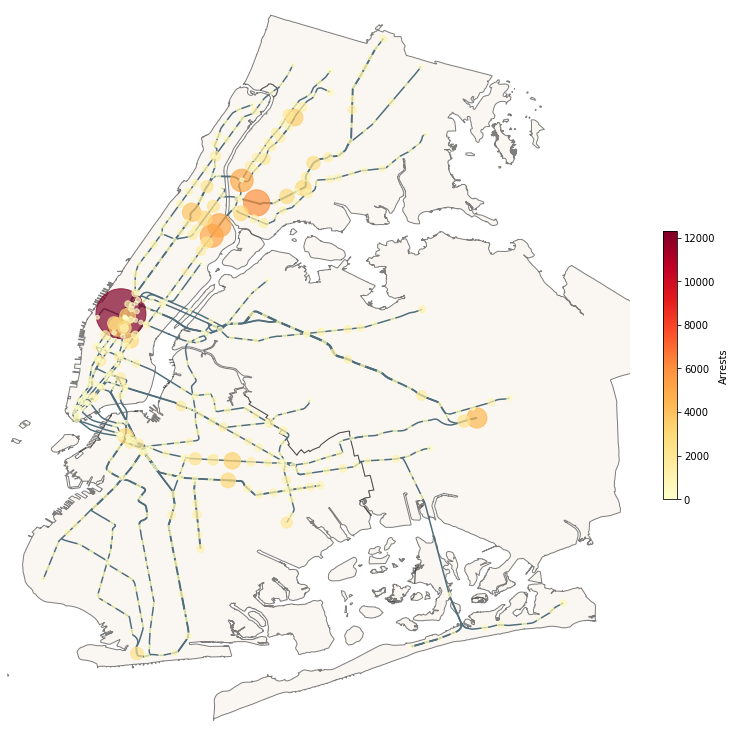

In [8]:
fig, ax = plt.subplots(figsize=(12,15))
ax.set_aspect('equal')

ax.axis('off')

borough_bound.plot(ax = ax, alpha=0.5, edgecolor='k',color='#F6F0E8')
subway_lines.plot(ax = ax, alpha=1, color='#4f6d7a')

gplt.pointplot(stations, ax=ax, scale='arrests', limits=(4, 50),
               label='Stations scaled by arrests', legend=True, legend_var='hue', 
                scheme = None, cmap='YlOrRd', hue='arrests', zorder=10, 
               legend_kwargs={'fraction':0.02, 'label':'Arrests'}, alpha=0.7)
ax.set_xlim((-74.05, -73.72))
ax.set_ylim((40.54, 40.92))
plt.savefig('Arrests_per_station.png',  bbox_inches='tight')

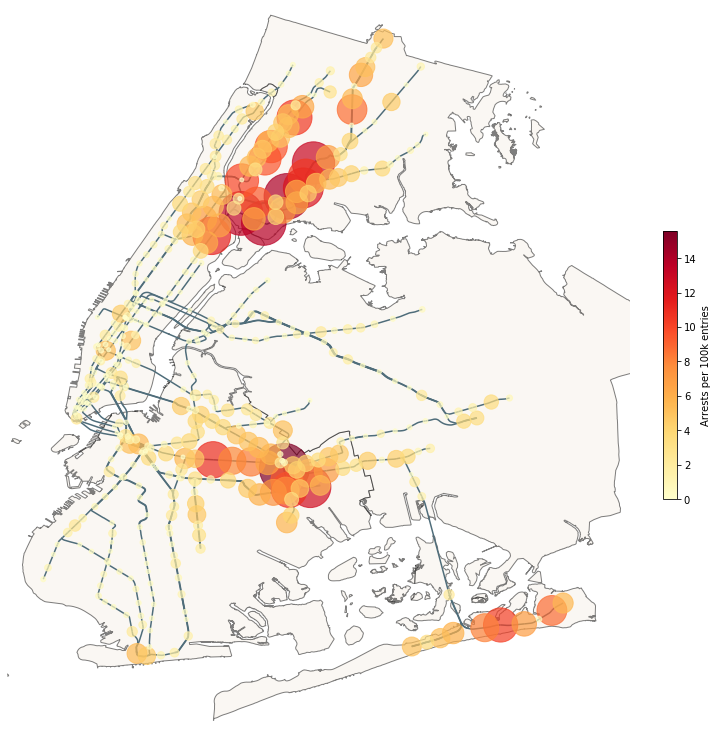

In [7]:
fig, ax = plt.subplots(figsize=(12,15))
ax.set_aspect('equal')

ax.axis('off')

borough_bound.plot(ax = ax, alpha=0.5, edgecolor='k',color='#F6F0E8')
subway_lines.plot(ax = ax, alpha=1, color='#4f6d7a')

gplt.pointplot(stations, ax=ax, scale='arrest_rate', limits=(4, 50),
               label='Stations scaled by arrests per 1k entries', legend=True, legend_var='hue', 
                scheme = None, cmap='YlOrRd', hue='arrest_rate', zorder=10, 
               legend_kwargs={'fraction':0.02, 'label':'Arrests per 100k entries'}, alpha=0.7)
ax.set_xlim((-74.05, -73.72))
ax.set_ylim((40.54, 40.92))
fig.savefig('Arrest_rates.png',  bbox_inches='tight')

In [26]:
stations['arrest_rate'].describe()

count    473.000000
mean       2.146843
std        2.763498
min        0.000000
25%        0.264019
50%        0.909032
75%        3.436643
max       15.557279
Name: arrest_rate, dtype: float64

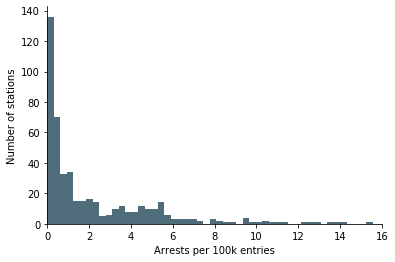

In [133]:
fig, ax = plt.subplots()
colors = ["#dd6e42","#e8dab2","#4f6d7a","#c0d6df", "#AAAE7F"]
#sns.kdeplot(stations['arrest_rate'], ax=ax, color=colors[2], legend=False)
stations.arrest_rate.hist(ax=ax, color=colors[2], bins=50, grid=False)
ax.set_xlabel('Arrests per 100k entries')
ax.set_xlim([0, 16])
#ax.title('Racial Makeup of Arrests at Subway Stops')
ax.set_ylabel('Number of stations')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig('Arrest Rate Dist.png', bboxinches='tight')

In [134]:
3.436643/0.909032

3.7805522797877305

In [135]:
15.557279/0.909032

17.11411589470998

In [61]:
stations['arrest_rate'].sort_values()

objectid
352.0     0.000000
277.0     0.000000
124.0     0.000000
424.0     0.000000
413.0     0.000570
           ...    
256.0    12.966358
27.0     13.487003
255.0    13.716971
254.0    14.095697
194.0    15.557279
Name: arrest_rate, Length: 473, dtype: float64

In [44]:
247/473

0.5221987315010571

In [9]:
def county_code(boro_code):
    if boro_code == 1:
        #manhattan
        return '061'
    if boro_code == 2:
        #bronx
        return '005'
    if boro_code == 3:
        #brooklyn
        return '047'
    if boro_code == 4:
        #queens
        return '081'
    if boro_code == 5:
        #staten island
        return '085'

census_tracts["GEO_ID"] = '1400000US36'+census_tracts.boro_code.astype(int).map(county_code)+census_tracts.ct2010

In [102]:
tract_data = census_tracts.merge(ACS_data, left_on = 'GEO_ID', right_index=True)

In [103]:
tract_data = gpd.GeoDataFrame(tract_data, geometry='geometry')

In [104]:
tract_data = tract_data[~(tract_data['Est: Total'] < 10)] #drop tracts with insufficient data

In [105]:
tract_data.columns

Index(['boro_code', 'boro_ct201', 'boro_name', 'cdeligibil', 'ct2010',
       'ctlabel', 'ntacode', 'ntaname', 'puma', 'shape_area', 'shape_leng',
       'geometry', 'GEO_ID', 'Est: Total', 'MoE: Total',
       'Est: Total: White alone', 'MoE: Total: White alone',
       'Est: Total: Black or African American alone',
       'MoE: Total: Black or African American alone',
       'Est: Total: American Indian and Alaska Native alone',
       'MoE: Total: American Indian and Alaska Native alone',
       'Est: Total: Asian alone', 'MoE: Total: Asian alone',
       'Est: Total: Native Hawaiian and Other Pacific Islander alone',
       'MoE: Total: Native Hawaiian and Other Pacific Islander alone',
       'Est: Total: Some other race alone',
       'MoE: Total: Some other race alone', 'Est: Total: Two or more races',
       'MoE: Total: Two or more races',
       'Est: Total: Two or more races: Two races including Some other race',
       'MoE: Total: Two or more races: Two races including Som

In [106]:
tract_data['black_rate'] = tract_data['Est: Total: Black or African American alone']*100/tract_data['Est: Total']
tract_data['poverty_rate'] = tract_data['Est: Poverty Status Past 12 Months']*100/tract_data['Est: Total']
tract_data['latino_rate'] = tract_data['Estimate!!Total!!Hispanic or Latino']*100/tract_data['Est: Total']
tract_data['BL_rate'] = (tract_data['Estimate!!Total!!Hispanic or Latino']+ tract_data['Estimate!!Total!!Not Hispanic or Latino!!Black or African American alone'])*100/tract_data['Est: Total']
tract_data['BL_poor_rate'] = (tract_data['Est: Poverty Status Past 12 Months (Black)'] + tract_data['Est: Poverty Status Past 12 Months (Hispanic or Latino)'])*100/tract_data['Est: Total']
tract_data['Black_poor_rate'] = (tract_data['Est: Poverty Status Past 12 Months (Black)'])*100/tract_data['Est: Total']
tract_data['Hispanic_poor_rate'] = (tract_data['Est: Poverty Status Past 12 Months (Hispanic or Latino)'])*100/tract_data['Est: Total']

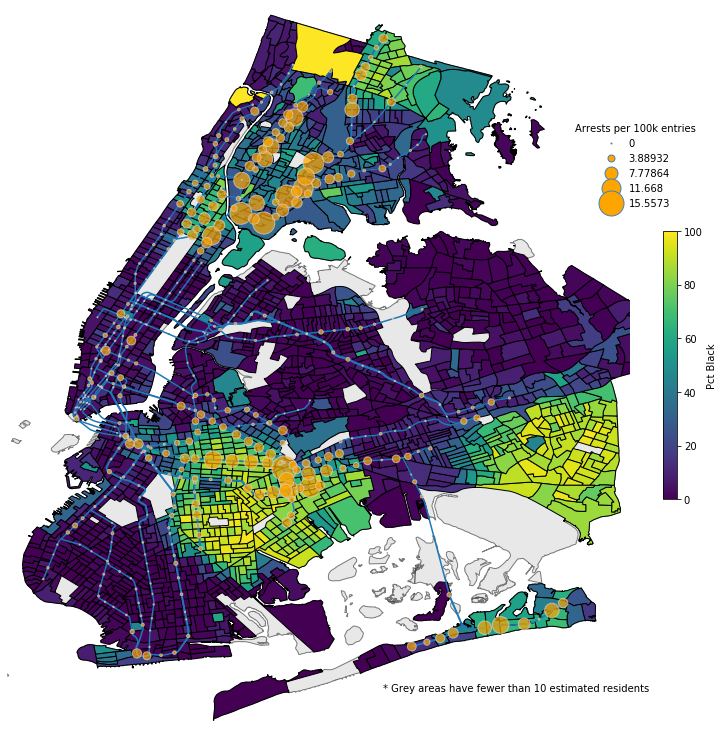

In [118]:
fig, ax = plt.subplots(figsize=(12,15))
ax.set_aspect('equal')
ax.set_xlim((-74.05, -73.7))
ax.set_ylim((40.54, 40.92))

borough_bound.plot(ax = ax, alpha=0.5, edgecolor='k',color='lightgrey')
subway_lines.plot(ax = ax, alpha=1)
gplt.pointplot(stations, ax=ax, scale='arrest_rate', limits=(1, 25), 
               label='Stations scaled by arrests per 100k entries', zorder=10, alpha=0.7, color='orange', edgecolors='lightgrey',
               legend=True, legend_kwargs={'title':'Arrests per 100k entries', 'loc':'upper right', 'frameon': False,
                               'bbox_to_anchor': (1.12, 0.85)})
gplt.choropleth(tract_data, ax = ax, hue='black_rate', legend=True, legend_kwargs={'fraction':0.02, 'label':'Pct Black'})
ax.set_xlim((-74.05, -73.72))
ax.set_ylim((40.54, 40.92))
plt.gcf().text(0.56, 0.2, '* Grey areas have fewer than 10 estimated residents', fontsize=10)
fig.savefig('arrests_and_black_pct.png', bbox_inches='tight')

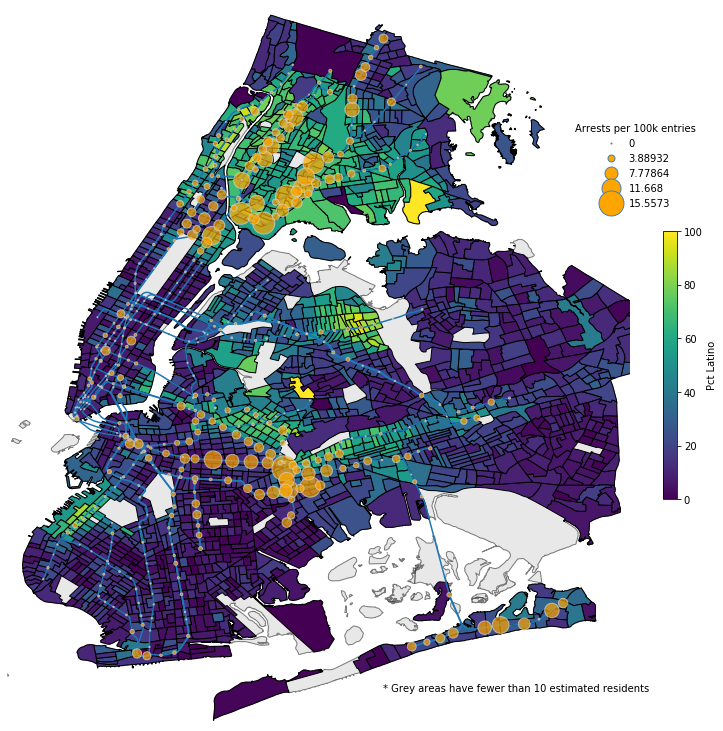

In [122]:
fig, ax = plt.subplots(figsize=(12,15))
ax.set_aspect('equal')
ax.set_xlim((-74.05, -73.7))
ax.set_ylim((40.54, 40.92))

borough_bound.plot(ax = ax, alpha=0.5, edgecolor='k',color='lightgrey')
subway_lines.plot(ax = ax, alpha=1)
gplt.pointplot(stations, ax=ax, scale='arrest_rate', limits=(1, 25), 
               label='Stations scaled by arrests per 100k entries', zorder=10, alpha=0.7, color='orange', edgecolors='lightgrey',
               legend=True, legend_kwargs={'title':'Arrests per 100k entries', 'loc':'upper right', 'frameon': False,
                               'bbox_to_anchor': (1.12, 0.85)})
gplt.choropleth(tract_data, ax = ax, hue='latino_rate', legend=True, legend_kwargs={'fraction':0.02, 'label':'Pct Latino'})
ax.set_xlim((-74.05, -73.72))
ax.set_ylim((40.54, 40.92))
plt.gcf().text(0.56, 0.2, '* Grey areas have fewer than 10 estimated residents', fontsize=10)
fig.savefig('arrests_and_latino_pct.png', bbox_inches='tight')

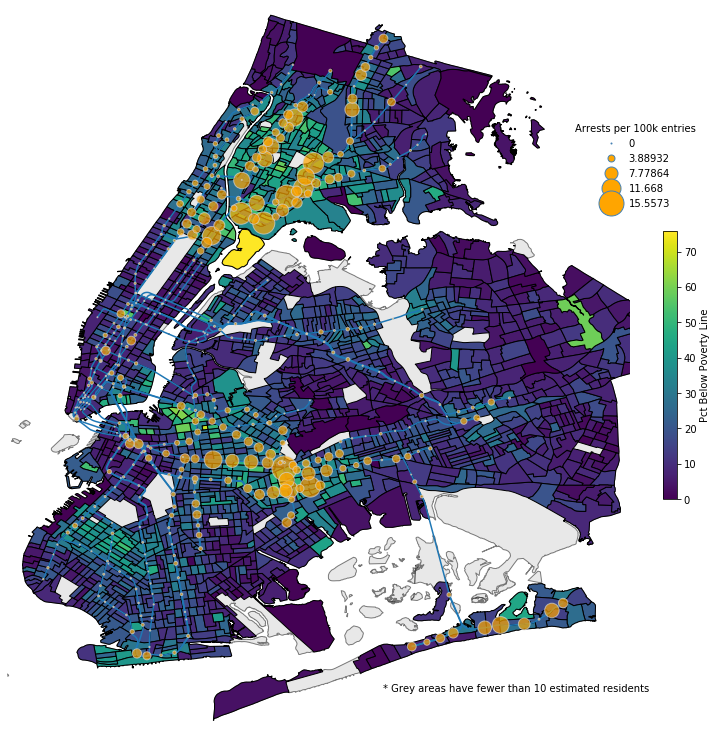

In [123]:
fig, ax = plt.subplots(figsize=(12,15))
ax.set_aspect('equal')
ax.set_xlim((-74.05, -73.7))
ax.set_ylim((40.54, 40.92))

borough_bound.plot(ax = ax, alpha=0.5, edgecolor='k',color='lightgrey')
subway_lines.plot(ax = ax, alpha=1)
gplt.pointplot(stations, ax=ax, scale='arrest_rate', limits=(1, 25), 
               label='Stations scaled by arrests per 100k entries', zorder=10, alpha=0.7, color='orange', edgecolors='lightgrey',
               legend=True, legend_kwargs={'title':'Arrests per 100k entries', 'loc':'upper right', 'frameon': False,
                               'bbox_to_anchor': (1.12, 0.85)})
gplt.choropleth(tract_data, ax = ax, hue='poverty_rate', legend=True, legend_kwargs={'fraction':0.02, 'label':'Pct Below Poverty Line'})
ax.set_xlim((-74.05, -73.72))
ax.set_ylim((40.54, 40.92))
plt.gcf().text(0.56, 0.2, '* Grey areas have fewer than 10 estimated residents', fontsize=10)
fig.savefig('arrests_and_poor_pct.png', bbox_inches='tight')

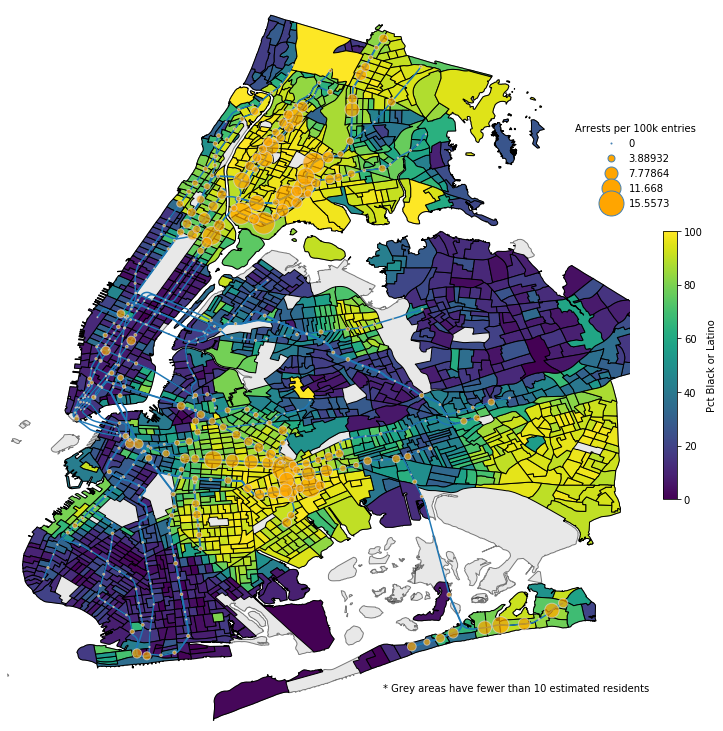

In [124]:
fig, ax = plt.subplots(figsize=(12,15))
ax.set_aspect('equal')
ax.set_xlim((-74.05, -73.7))
ax.set_ylim((40.54, 40.92))

borough_bound.plot(ax = ax, alpha=0.5, edgecolor='k',color='lightgrey')
subway_lines.plot(ax = ax, alpha=1)
gplt.pointplot(stations, ax=ax, scale='arrest_rate', limits=(1, 25), 
               label='Stations scaled by arrests per 100k entries', zorder=10, alpha=0.7, color='orange', edgecolors='lightgrey',
               legend=True, legend_kwargs={'title':'Arrests per 100k entries', 'loc':'upper right', 'frameon': False,
                               'bbox_to_anchor': (1.12, 0.85)})
gplt.choropleth(tract_data, ax = ax, hue='BL_rate', legend=True, legend_kwargs={'fraction':0.02, 'label':'Pct Black or Latino'})
ax.set_xlim((-74.05, -73.72))
ax.set_ylim((40.54, 40.92))
plt.gcf().text(0.56, 0.2, '* Grey areas have fewer than 10 estimated residents', fontsize=10)

fig.savefig('arrests_and_black_or_latino_pct.png', bbox_inches='tight')

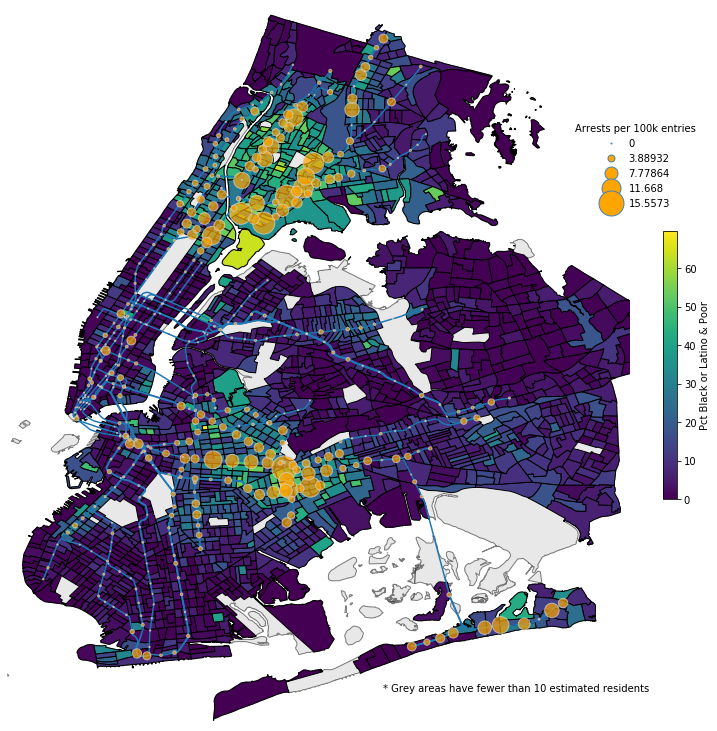

In [125]:
fig, ax = plt.subplots(figsize=(12,15))
ax.set_aspect('equal')
ax.set_xlim((-74.05, -73.7))
ax.set_ylim((40.54, 40.92))

borough_bound.plot(ax = ax, alpha=0.5, edgecolor='k',color='lightgrey')
subway_lines.plot(ax = ax, alpha=1)
gplt.pointplot(stations, ax=ax, scale='arrest_rate', limits=(1, 25), 
               label='Stations scaled by arrests per 100k entries', zorder=10, alpha=0.7, color='orange', edgecolors='lightgrey',
               legend=True, legend_kwargs={'title':'Arrests per 100k entries', 'loc':'upper right', 'frameon': False,
                               'bbox_to_anchor': (1.12, 0.85)})
gplt.choropleth(tract_data, ax = ax, hue='BL_poor_rate', legend=True, legend_kwargs={'fraction':0.02, 'label':'Pct Black or Latino & Poor'})
ax.set_xlim((-74.05, -73.72))
ax.set_ylim((40.54, 40.92))
plt.gcf().text(0.56, 0.2, '* Grey areas have fewer than 10 estimated residents', fontsize=10)
fig.savefig('arrests_and_black_latino_and_poor_pct.png', bbox_inches='tight')

(40.54, 40.92)

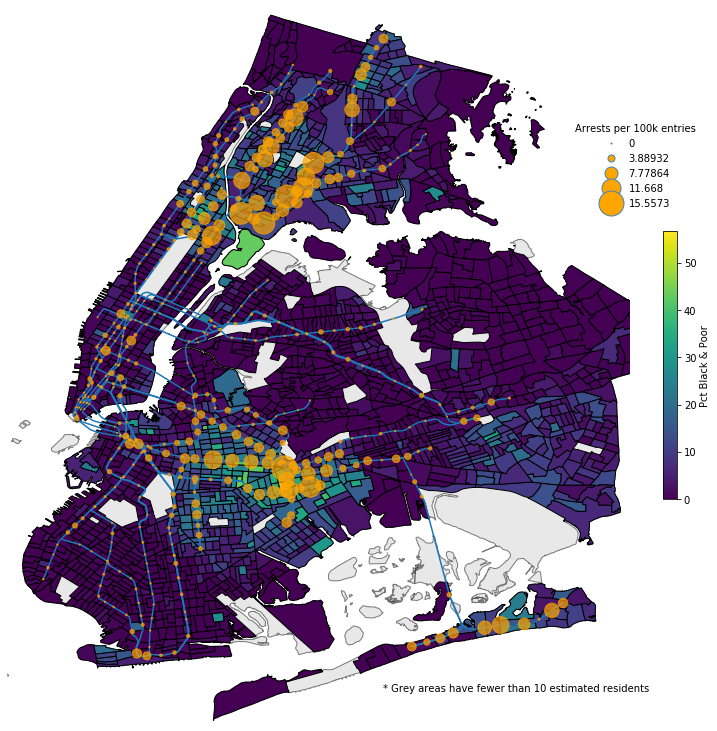

In [127]:
fig, ax = plt.subplots(figsize=(12,15))
ax.set_aspect('equal')
ax.set_xlim((-74.05, -73.7))
ax.set_ylim((40.54, 40.92))

borough_bound.plot(ax = ax, alpha=0.5, edgecolor='k',color='lightgrey')
subway_lines.plot(ax = ax, alpha=1)
gplt.pointplot(stations, ax=ax, scale='arrest_rate', limits=(1, 25),
               label='Stations scaled by arrests per 100k entries', zorder=10, alpha=0.7,color='orange', legend=True
               , legend_kwargs={'title':'Arrests per 100k entries', 'loc':'upper right', 'frameon': False,
                               'bbox_to_anchor': (1.12, 0.85)})
gplt.choropleth(tract_data, ax = ax, hue='Black_poor_rate', legend=True, legend_kwargs={'fraction':0.02, 'label':'Pct Black & Poor'})
plt.gcf().text(0.56, 0.2, '* Grey areas have fewer than 10 estimated residents', fontsize=10)

ax.set_xlim((-74.05, -73.72))
ax.set_ylim((40.54, 40.92))

(40.54, 40.92)

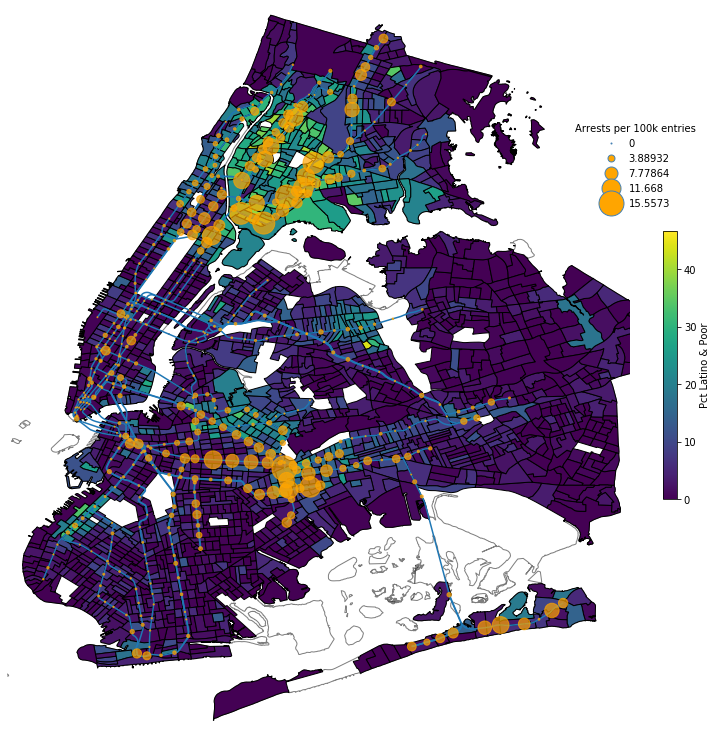

In [89]:
fig, ax = plt.subplots(figsize=(12,15))
ax.set_aspect('equal')
ax.set_xlim((-74.05, -73.7))
ax.set_ylim((40.54, 40.92))

borough_bound.plot(ax = ax, alpha=0.5, edgecolor='k',color='white')
subway_lines.plot(ax = ax, alpha=1)
gplt.pointplot(stations, ax=ax, scale='arrest_rate', limits=(1, 25),
               label='Stations scaled by arrests per 100k entries', zorder=10, alpha=0.7,color='orange', legend=True
               , legend_kwargs={'title':'Arrests per 100k entries', 'loc':'upper right', 'frameon': False,
                               'bbox_to_anchor': (1.12, 0.85)})
gplt.choropleth(tract_data, ax = ax, hue='Hispanic_poor_rate', legend=True, legend_kwargs={'fraction':0.02, 'label':'Pct Latino & Poor'})
ax.set_xlim((-74.05, -73.72))
ax.set_ylim((40.54, 40.92))